# Measure distance between spectrograms using Dynamic Time Warping and Optimal Transport
In this example, we will explore [Dynamic Time Warping (DTW)](https://en.wikipedia.org/wiki/Dynamic_time_warping) and see if we can combine it with optimal transport. The application is distance measurement between two spectrograms. The Euclidean distance is typically poorly suited for this task, even if we allow some warping along the time axis. The reason is that even a small shift in frequencies produces a large difference in Euclidean distance. This problem is described in more detail in ["New Metrics Between Rational Spectra and their Connection to Optimal Transport", Bagge and Chitre 2020](https://arxiv.org/abs/2004.09152). 
We would thus like to use a transport-based (Wasserstein) distance along the frequency axis, and let the time warping take care of shifts along the time axis.

In [22]:
using DynamicAxisWarping, DSP, LPVSpectral, Distances, Plots, Suppressor

We start by creating two signals. The two signals will be the same, but shifted along the time axis.

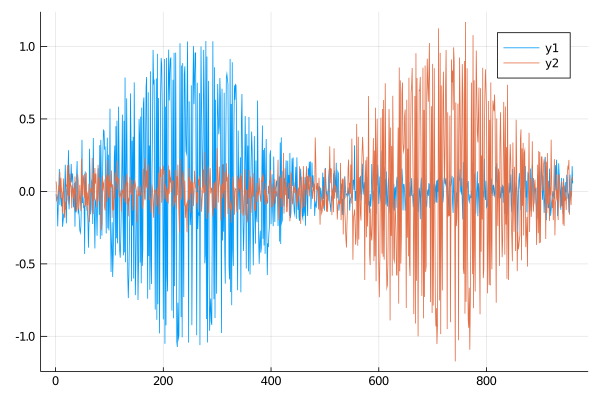

In [7]:
N = 48_000
g(x,N) = exp(-10*(x-N/2)^2/N^2)
t = 1:N
f = range(0.01, stop=1, length=N)
y = sin.(t .* f) .* g.(t, N)
y1 = [y; 0y] .+ 0.1 .* randn.()
y2 = [0y; y] .+ 0.1 .* randn.()

plot([y1 y2][1:100:end,:])

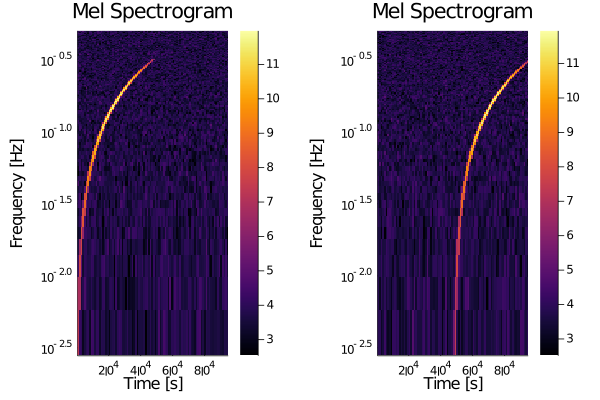

In [24]:
M1,M2 = melspectrogram.((y1,y2), 2048)
@suppress plot(plot(M1), plot(M2))

We then calculate the Dynamic Time-Warping cost between them (I do this in √ domain since that appears to produce the nicest looking plots)

In [16]:
dtw(.√(M1.power), .√(M2.power))[1]

400275.6637208654

Visualize the coupling matrix. The green line should cross diagonally (since the two signals are the same) starting halfway along the axes (since one signal is shifted by 50% of the length copared to the other).

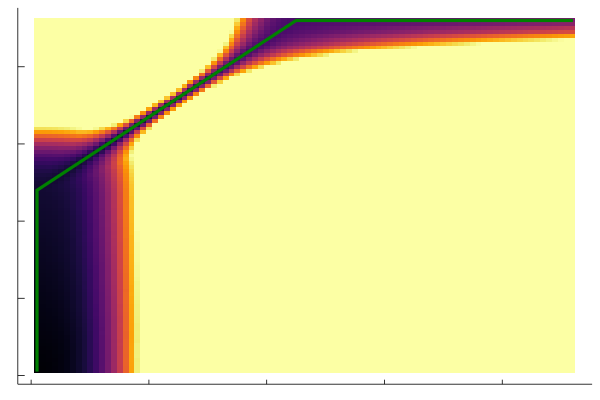

In [25]:
@suppress dtwplot(.√(M1.power), .√(M2.power), linecolor=:green)

The code above used the squared Euclidean distance between spectra for each time point. We can replace that distance with a transport-based distance instead.
We thus combine dynamic time warping with a transport-based cost along the frequency axis

In [26]:
using SpectralDistances
n,m = size(M1.power)
dist = DiscreteGridTransportDistance(SqEuclidean(), n, n)
dtw(.√(M1.power), .√(M2.power), dist)[1]

2053.154121418348

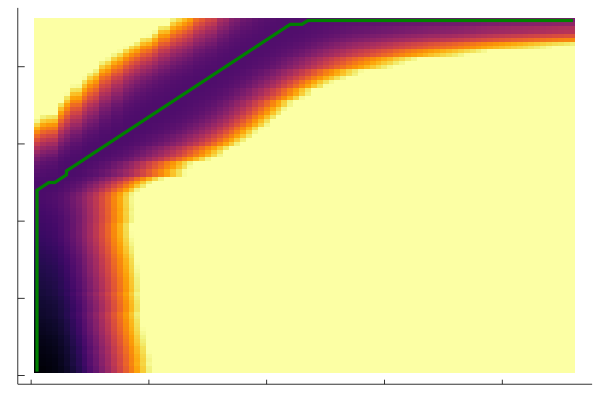

In [27]:
@suppress dtwplot(.√(M1.power), .√(M2.power), dist, linecolor=:green)

We now see that the valley through which the path can move is slightly wider. This happens since there is now an additional degree of freedom due to transport along the frequency axis. Since there is no need for that transport in this case, the resulting path remains almost the same.
We can create the need for some transport along the frequency axis by modifying one of the chirps

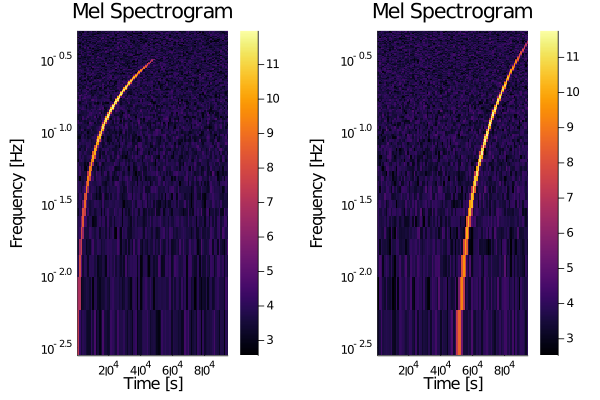

In [28]:
f1 = range(0.01, stop=1, length=N)
f2 = range(0.1, stop=1, length=N).^2
y10 = sin.(t .* f1) .* g.(t, N)
y20 = sin.(t .* f2) .* g.(t, N)
y1 = [y10; 0y10] .+ 0.1 .* randn.()
y2 = [0y20; y20] .+ 0.1 .* randn.()
M1,M2 = melspectrogram.((y1,y2), 2048)
@suppress plot(plot(M1), plot(M2))

We now redo the same stuff as above

In [29]:
dtw(.√(M1.power), .√(M2.power))[1]

2.21887981339534e6

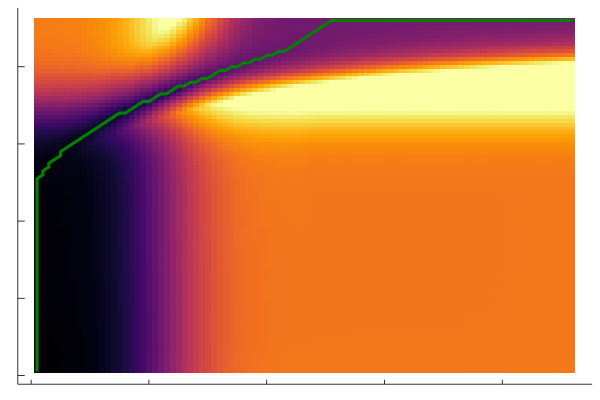

In [30]:
@suppress dtwplot(.√(M1.power), .√(M2.power), linecolor=:green)

We now see that the signal coupling has been warped, the green line does no longer cut straight through the map, rather, it is kind-of crooked.

In [32]:
dtw(.√(M1.power), .√(M2.power), dist)[1]

5384.592073819727

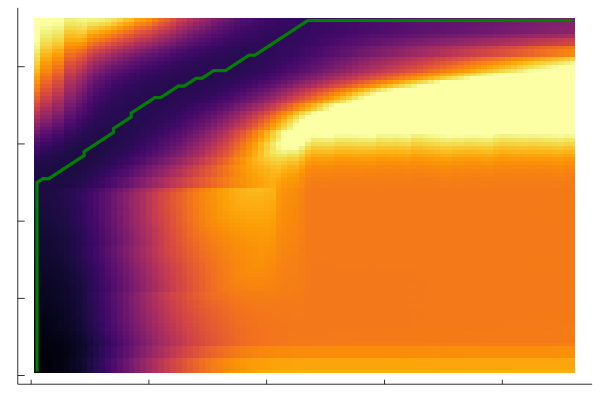

In [33]:
@suppress dtwplot(.√(M1.power), .√(M2.power), dist, linecolor=:green)

With the transport-based loss, we expect to see less time warping (straighter green line) since now it's allowed to fudge the distance a bit by shuffling mass along the frequency axis.
How long time does it take to compute such a distance? (on a laptop, expect about 3x improvement on desktop)

In [34]:
@btime dtw($(M1.power), $(M2.power), $dist)

  252.142 ms (33957 allocations: 10.28 MiB)


(59127.46353764505, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  83, 84, 85, 86, 87, 88, 89, 90, 91, 92], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  92, 92, 92, 92, 92, 92, 92, 92, 92, 92])

The size of the spectrogram

In [35]:
size(M1.power)

(128, 92)

The complexity is almost linear in the number of frequency bins, but quadratic in the number of time steps. There are wuite some things that can be done to speed things up. Apart from the obvious use of multiple threads, one can also radius-limit the search, so that only a band around the main diagonal of the coupling matrix is computed.